In [1]:
# FEniCS for spatial FEM
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Create temporal basis in SymPy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Mul, Id, symbols, init_printing, expand, compose, diff, lambdify, Piecewise
from IPython.display import Math, display
from fenics import IntervalMesh, Function, TestFunction, TestFunctions, FunctionSpace, dx, inner, grad, FiniteElement, MixedElement, Constant, assemble, Expression, interpolate, solve, DirichletBC, plot, errornorm, set_log_active
from ufl import replace
import time
import pandas as pd

set_log_active(False) # turn off FEniCS logging

t = symbols("t")
init_printing()

# HELPER FUNCTIONS
# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j]))
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, 1]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append((root + 1) / 2)
    return new_roots

# dictionary of temporal bases depending on the polynomial degree
# FE basis on reference element (0,1)
φ = {}
roots = {}

roots[0] = [1.]
φ[0] = [1 + 0*Id(t)]
roots[1] = [0., 1.]
φ[1] = [1-t, t]
roots[2] = transform_roots([-1, 0, 1])
φ[2] = compute_basis_functions(roots[2])
#roots[3] = transform_roots([-1, -sqrt(Rational(1,5)), sqrt(Rational(1,5)), 1])
#φ[3] = compute_basis_functions(roots[3])

class TimeFE:
    def __init__(self, r=1, a=0., b=1., n_time=1, n_q_points=3):
        self.r = r # polynomial degree in time
        self.n_time = n_time # number of temporal elements
        self.n_dofs = (self.r+1) * self.n_time # total number of temporal dofs on slab
        self.dof_locations = []
        self.a = a # start time of slab
        self.b = b # end time of slab
        self.k = (self.b - self.a) / self.n_time
        self.epsilon = self.k * 1e-14

        self.generate_mesh()
        self.get_full_basis()
        self.lambdify_basis()
        self.compute_quadrature(n_q_points)

    def generate_mesh(self):
        # create an uniform temporal mesh with mesh size self.k
        self.mesh = [(self.a, self.a+self.k)]
        while len(self.mesh) < self.n_time:
            self.mesh.append((self.mesh[-1][1], self.mesh[-1][1]+self.k))

    # transform basis functions from [0,1] to [a,b]
    def transform_function(self, f, a, b):
        return compose(f, (t-a)/(b-a)) # = f((t-a)/(b-a))

    # get full FE basis and its derivative on temporal mesh
    def get_full_basis(self):
        self._basis = []
        self._basis_derivative = []
        self.local_dofs = {}
        i = 0
        for (a,b) in self.mesh:
            self.local_dofs[(a,b)] = []
            for f, t_q in zip(φ[self.r], roots[self.r]):
                self._basis.append(self.transform_function(f, a, b))
                self._basis_derivative.append(diff(self._basis[-1],t))
                self.local_dofs[(a,b)].append(i)
                self.dof_locations.append(t_q*(b-a)+a)
                i += 1

    # convert SymPy functions to Python functions and ensure that they are 0 outside the element that they are defined on
    def lambdify_basis(self):
        self.phi = []
        self.dt_phi = []

        for (a,b) in self.mesh:
            for i in self.local_dofs[(a,b)]:
                self.phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis[i], True)
                        )
                    )
                )

                self.dt_phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis_derivative[i], True)
                        )
                    )
                )

    def compute_quadrature(self, n_q_points):
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]
            
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points+2)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature_fine = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature_fine[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]

    def plot_basis(self, basis_type="function", title=None):
        assert basis_type in ["function", "derivative"], f"basis_type='{basis_type}' has not been implemented."

        _t = np.linspace(self.a, self.b, 100)
        for i in range(len(self.phi)):
            if basis_type == "function":
                plt.plot(_t, [self.phi[i](time_point) for time_point in _t], label=rf"$\varphi_{{{i}}}$")
            elif basis_type == "derivative":
                plt.plot(_t, [self.dt_phi[i](time_point) for time_point in _t], label=rf"$\partial_t \varphi_{{{i}}}$")

        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.legend()
        if title is not None:
            plt.title(title)
        plt.show()
        
    def get_solution_at_time(self, time_point, Vh):
        tmp = interpolate(Constant(0.), Vh)
        for i in range(self.n_dofs):
            tmp += Time.phi[i](time_point) * U[i]
        return tmp

## Assemble space-time integrals using numerical quadrature in time and FEniCS forms in space

CONFIG: r = 0, slab_size = 0.5, n_x = 2
Solving on slab_0 = Ω x (0.0, 0.5) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done.

------------
| RESULTS: |
------------
Space-time Dofs: 6
L2 error: 7.846967407471544e-05
CPU Time: 0.89329 s 


CONFIG: r = 0, slab_size = 0.25, n_x = 4
Solving on slab_0 = Ω x (0.0, 0.25) ...
Done.

Solving on slab_1 = Ω x (0.25, 0.5) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done.

------------
| RESULTS: |
------------
Space-time Dofs: 20
L2 error: 6.128204957733417e-05
CPU Time: 1.05503 s 


CONFIG: r = 0, slab_size = 0.125, n_x = 8
Solving on slab_0 = Ω x (0.0, 0.125) ...
Done.

Solving on slab_1 = Ω x (0.125, 0.25) ...
Done.

Solving on slab_2 = Ω x (0.25, 0.375) ...
Done.

Solving on slab_3 = Ω x (0.375, 0.5) ...
Done.

------------
| RESULTS: |
------------
Space-time Do

Calling FFC just-in-time (JIT) compiler, this may take some time.
Done.

------------
| RESULTS: |
------------
Space-time Dofs: 12
L2 error: 0.00029652187739511273
CPU Time: 1.72908 s 


CONFIG: r = 1, slab_size = 0.25, n_x = 4
Solving on slab_0 = Ω x (0.0, 0.25) ...
Done.

Solving on slab_1 = Ω x (0.25, 0.5) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done.

------------
| RESULTS: |
------------
Space-time Dofs: 40
L2 error: 0.00018113588425901643
CPU Time: 1.52108 s 


CONFIG: r = 1, slab_size = 0.125, n_x = 8
Solving on slab_0 = Ω x (0.0, 0.125) ...
Done.

Solving on slab_1 = Ω x (0.125, 0.25) ...
Done.

Solving on slab_2 = Ω x (0.25, 0.375) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done.

Solving on slab_3 = Ω x (0.375, 0.5) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Cal

Done.

Solving on slab_58 = Ω x (0.45312, 0.46094) ...
Done.

Solving on slab_59 = Ω x (0.46094, 0.46875) ...
Done.

Solving on slab_60 = Ω x (0.46875, 0.47656) ...
Done.

Solving on slab_61 = Ω x (0.47656, 0.48438) ...
Done.

Solving on slab_62 = Ω x (0.48438, 0.49219) ...
Done.

Solving on slab_63 = Ω x (0.49219, 0.5) ...
Done.

------------
| RESULTS: |
------------
Space-time Dofs: 33024
L2 error: 2.599623802435911e-07
CPU Time: 10.48949 s 


CONFIG: r = 2, slab_size = 0.5, n_x = 2
Solving on slab_0 = Ω x (0.0, 0.5) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done.

------------
| RESULTS: |
------------
Space-time Dofs: 18
L2 error: 0.0003452546885989485
CPU Time: 4.11274 s 


CONFIG: r = 2, slab_size = 0.25, n_x = 4
Solving on slab_0 = Ω x (0.0, 0.25) ...
Done.

Solving on slab_1 = Ω x (0.25, 0.5) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-tim

Done.

Solving on slab_31 = Ω x (0.24219, 0.25) ...
Done.

Solving on slab_32 = Ω x (0.25, 0.25781) ...
Done.

Solving on slab_33 = Ω x (0.25781, 0.26562) ...
Done.

Solving on slab_34 = Ω x (0.26562, 0.27344) ...
Done.

Solving on slab_35 = Ω x (0.27344, 0.28125) ...
Done.

Solving on slab_36 = Ω x (0.28125, 0.28906) ...
Done.

Solving on slab_37 = Ω x (0.28906, 0.29688) ...
Done.

Solving on slab_38 = Ω x (0.29688, 0.30469) ...
Done.

Solving on slab_39 = Ω x (0.30469, 0.3125) ...
Done.

Solving on slab_40 = Ω x (0.3125, 0.32031) ...
Done.

Solving on slab_41 = Ω x (0.32031, 0.32812) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done.

Solving on slab_42 = Ω x (0.32812, 0.33594) ...
Done.

Solving on slab_43 = Ω x (0.33594, 0.34375) ...
Done.

Solving on slab_44 = Ω x (0.34375, 0.35156) ...
Done.

Solving on slab_45 = Ω x (0.35156, 0.35938) ...
Done.

Solving on slab_46 = Ω x (0.35938, 0.36719) 

Done.

Solving on slab_29 = Ω x (0.22656, 0.23438) ...
Done.

Solving on slab_30 = Ω x (0.23438, 0.24219) ...
Done.

Solving on slab_31 = Ω x (0.24219, 0.25) ...
Done.

Solving on slab_32 = Ω x (0.25, 0.25781) ...
Done.

Solving on slab_33 = Ω x (0.25781, 0.26562) ...
Done.

Solving on slab_34 = Ω x (0.26562, 0.27344) ...
Done.

Solving on slab_35 = Ω x (0.27344, 0.28125) ...
Done.

Solving on slab_36 = Ω x (0.28125, 0.28906) ...
Done.

Solving on slab_37 = Ω x (0.28906, 0.29688) ...
Done.

Solving on slab_38 = Ω x (0.29688, 0.30469) ...
Done.

Solving on slab_39 = Ω x (0.30469, 0.3125) ...
Done.

Solving on slab_40 = Ω x (0.3125, 0.32031) ...
Done.

Solving on slab_41 = Ω x (0.32031, 0.32812) ...
Done.

Solving on slab_42 = Ω x (0.32812, 0.33594) ...
Done.

Solving on slab_43 = Ω x (0.33594, 0.34375) ...
Done.

Solving on slab_44 = Ω x (0.34375, 0.35156) ...
Done.

Solving on slab_45 = Ω x (0.35156, 0.35938) ...
Done.

Solving on slab_46 = Ω x (0.35938, 0.36719) ...
Done.

Solving on 

Done.

Solving on slab_22 = Ω x (0.17188, 0.17969) ...
Done.

Solving on slab_23 = Ω x (0.17969, 0.1875) ...
Done.

Solving on slab_24 = Ω x (0.1875, 0.19531) ...
Done.

Solving on slab_25 = Ω x (0.19531, 0.20312) ...
Done.

Solving on slab_26 = Ω x (0.20312, 0.21094) ...
Done.

Solving on slab_27 = Ω x (0.21094, 0.21875) ...
Done.

Solving on slab_28 = Ω x (0.21875, 0.22656) ...
Done.

Solving on slab_29 = Ω x (0.22656, 0.23438) ...
Done.

Solving on slab_30 = Ω x (0.23438, 0.24219) ...
Done.

Solving on slab_31 = Ω x (0.24219, 0.25) ...
Done.

Solving on slab_32 = Ω x (0.25, 0.25781) ...
Done.

Solving on slab_33 = Ω x (0.25781, 0.26562) ...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Done.

Solving on slab_34 = Ω x (0.26562, 0.27344) ...
Done.

Solving on slab_35 = Ω x (0.27344, 0.28125) ...
Done.

Solving on slab_36 = Ω x (0.28125, 0.28906) ...
Done.

Solving on slab_37 = Ω x (0.28906, 0.29688) 

Done.

Solving on slab_26 = Ω x (0.40625, 0.42188) ...
Done.

Solving on slab_27 = Ω x (0.42188, 0.4375) ...
Done.

Solving on slab_28 = Ω x (0.4375, 0.45312) ...
Done.

Solving on slab_29 = Ω x (0.45312, 0.46875) ...
Done.

Solving on slab_30 = Ω x (0.46875, 0.48438) ...
Done.

Solving on slab_31 = Ω x (0.48438, 0.5) ...
Done.

------------
| RESULTS: |
------------
Space-time Dofs: 24768
L2 error: 1.0271958272275718e-06
CPU Time: 22.18043 s 


CONFIG: r = 2, slab_size = 0.0078125, n_x = 128
Solving on slab_0 = Ω x (0.0, 0.00781) ...
Done.

Solving on slab_1 = Ω x (0.00781, 0.01562) ...
Done.

Solving on slab_2 = Ω x (0.01562, 0.02344) ...
Done.

Solving on slab_3 = Ω x (0.02344, 0.03125) ...
Done.

Solving on slab_4 = Ω x (0.03125, 0.03906) ...
Done.

Solving on slab_5 = Ω x (0.03906, 0.04688) ...
Done.

Solving on slab_6 = Ω x (0.04688, 0.05469) ...
Done.

Solving on slab_7 = Ω x (0.05469, 0.0625) ...
Done.

Solving on slab_8 = Ω x (0.0625, 0.07031) ...
Done.

Solving on slab_9 = Ω 

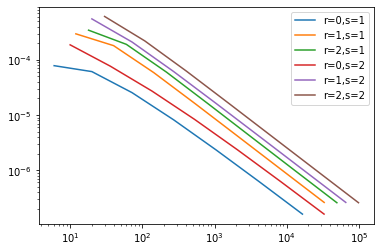

In [18]:
##############################################
# Start a time marching / time slabbing loop #
##############################################
start_time = 0.
end_time = 0.5

conv_table_start_time = time.time()
convergence_table = {}
for s in [1, 2]: # polynomial degree in space
    for r in [0, 1, 2]: # polynomial degree in time
        convergence_table[r, s] = {}
        slab_size = 1.
        n_x = 1
        for i in range(7): #8):
            slab_size *= 0.5
            n_x *= 2
        #for slab_size in [0.5**i*0.5 for i in range(6)]: #8)]:
            #for n_x in [2**i for i in range(6)]: #[10, 20, 40, 80, 160, 320]: # number of spatial elements in x-direction
                
            # start simulation
            cpu_start_time = time.time()
            print(f"CONFIG: r = {r}, slab_size = {slab_size}, n_x = {n_x}")

            slabs = [(start_time, start_time+slab_size)]
            while slabs[-1][1] < end_time - 1e-8:
                slabs.append((slabs[-1][1], slabs[-1][1]+slab_size))

            # get spatial function space
            space_mesh = IntervalMesh(n_x, 0., 1.) # \Omega = (0,1)
            Vh = FunctionSpace(space_mesh, 'CG', s) # spatial function space for a single time point
            uh = Function(Vh)
            phih = TestFunction(Vh)

            # analytical solution
            u_analytical = Expression('sin(pi*x[0])*(1.+t)*exp(-0.5*t)', degree=4, pi=np.pi, t=0.)

            # initial condition on slab
            u0 = Function(Vh)
            u0 = interpolate(u_analytical, Vh)

            # preassemble spatial forms
            mass_form = uh*phih*dx
            laplace_form = inner(grad(uh), grad(phih))*dx

            L2_error = 0.
            total_n_dofs = 0
            total_time_n_dofs = 0

            #####################
            # Time slabbing loop:
            for k, slab in enumerate(slabs):
                print(f"Solving on slab_{k} = Ω x ({round(slab[0],5)}, {round(slab[1],5)}) ...")

                #########################################
                # Create temporal finite element object #
                #########################################
                Time = TimeFE(r=r, a=slab[0], b=slab[1], n_time=2, n_q_points=r+1)

                element_u = FiniteElement("CG", space_mesh.ufl_cell(), s)
                V = FunctionSpace(space_mesh, MixedElement(*[element_u for _ in range(Time.n_dofs)]))

                U = Function(V)
                Phi = TestFunctions(V)

                # start with "empty" space-time variational form
                F = Constant(0.)*Phi[0]*dx
                rhs_force = Expression('sin(pi*x[0])*exp(-0.5*t)*(0.5+pow(pi,2)+(pow(pi,2)-0.5)*t)', degree=4, pi=np.pi, t=0.)

                # volume integrals
                for time_element in Time.mesh:
                    for i in Time.local_dofs[time_element]:
                        for j in Time.local_dofs[time_element]:
                            for (t_q, w_q) in Time.quadrature[time_element]:
                                F += Constant(w_q * Time.dt_phi[j](t_q) * Time.phi[i](t_q)) * replace(mass_form, {uh: U[j], phih: Phi[i]})
                                F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) * replace(laplace_form, {uh: U[j], phih: Phi[i]})

                # RHS integral
                for n, time_element in enumerate(Time.mesh):
                    for i in Time.local_dofs[time_element]:
                        # initial condition
                        if n == 0:
                            F -=  Constant(Time.phi[i](time_element[0]+Time.epsilon)) * u0 * Phi[i] * dx

                        for (t_q, w_q) in Time.quadrature_fine[time_element]:
                            # forcing function
                            rhs_force.t = t_q
                            F -= Constant(w_q * Time.phi[i](t_q)) * rhs_force * Phi[i] * dx 


                # jump terms (NOTE: For Gauss-Lobatto dG basis, we can hard code the values for the jump term)
                for n, time_element in enumerate(Time.mesh):
                    # a) u_m^+ * φ_m^+
                    for i in Time.local_dofs[time_element]:
                        for j in Time.local_dofs[time_element]:
                            F += Constant(Time.phi[j](time_element[0]+Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * replace(mass_form, {uh: U[j], phih: Phi[i]})


                    # b) u_{m-1}^- * φ_m^+
                    if n > 0:
                        prev_time_element = Time.mesh[n-1]
                        for i in Time.local_dofs[time_element]:
                            for j in Time.local_dofs[prev_time_element]:
                                F += Constant((-1.) * Time.phi[j](prev_time_element[1]-Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * replace(mass_form, {uh: U[j], phih: Phi[i]})

                # define time dependent Dirichelt boundary conditions
                bcs = []
                for i, t_q in enumerate(Time.dof_locations):
                    u_analytical.t = t_q
                    if Time.n_dofs > 1:
                        bcs.append(DirichletBC(V.sub(i), u_analytical, lambda _, on_boundary: on_boundary))
                    else:
                        # for dG(0) with 1 temporal element Vh = V
                        raise NotImplementedError("Make sure that Time.n_dofs > 1, because otherwise V.sub(i) doesn't work")

                # solve problem
                solve(F == 0, U, bcs) #, tol=5e-6, M=Expression("exp(x[0])", degree=2)*U[0]*dx) # TODO: adapt to adaptive mesh refinement

                # get u0 for next slab
                u0 = Time.get_solution_at_time(slab[1]-Time.epsilon, Vh) #Vh_new)

                # plot solution
                #plot(u0, label="FEM")
                #plt.show()
                #u_analytical.t = slab[1]
                #tmp = interpolate(u_analytical, Vh)
                #plot(tmp, label="analytical")
                #plt.legend()
                #plt.show()

                # prepare convergence plot
                total_time_n_dofs += Time.n_dofs
                total_n_dofs += Vh.dim() * Time.n_dofs 
                for time_element in Time.mesh:
                    for (t_q, w_q) in Time.quadrature_fine[time_element]:
                        u_q_FEM = Time.get_solution_at_time(t_q, Vh)
                        u_analytical.t = slab[1]
                        u_q_analytical = interpolate(u_analytical, Vh)
                        L2_error += w_q * assemble((u_q_analytical-u_q_FEM)**2*dx)

                print("Done.\n")

            print("------------")
            print("| RESULTS: |")
            print("------------")
            print(f"Space-time Dofs: {total_n_dofs}")
            print("L2 error:", L2_error)
            cpu_time = round(time.time() - cpu_start_time, 5)
            print(f"CPU Time: {cpu_time} s \n\n")
            convergence_table[r, s][Vh.dim(), total_time_n_dofs] = {"dofs": total_n_dofs, "error": f"{L2_error:.3e}", "time": cpu_time}
                         
print(f"\n\nTime for creating convergence table: {round(time.time() - conv_table_start_time, 5)} s")
print("Convergence table:")
for (r, s) in convergence_table.keys():
    #x_index, y_index = set(), set()
    #for (x_ind, y_ind) in convergence_table[r, s].keys():
    #    x_index.add(x_ind)
    #    y_index.add(y_ind)
    #data = {y_ind : [convergence_table[r, s][x_ind, y_ind]["error"] for x_ind in sorted(list(x_index))] for y_ind in sorted(list(y_index))}
    #df = pd.DataFrame(data, index=sorted(list(x_index)))
    #print(df)
    print(f"r = {r}, s = {s}:", convergence_table[r, s])
    X = []
    Y = []
    for val in convergence_table[r, s].values():
        X.append(val["dofs"])
        Y.append(float(val["error"]))
    plt.plot(X, Y, label=f"r={r},s={s}")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

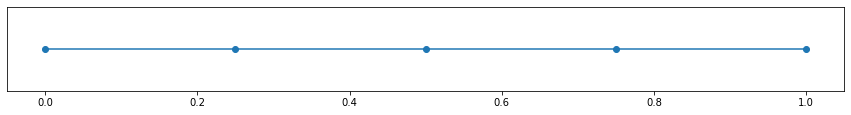

In [153]:
# TODO: use this later for adaptive mesh refinement
plt.rcParams["figure.figsize"] = [15,15]
plot(U.leaf_node().ufl_function_space().mesh())
plt.show()